In [31]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from astropy.io import fits

In [32]:
with fits.open('../data/df_v_final.fits') as hdul:
    data = hdul[1].data
    df_v = pd.DataFrame({
        col.name: data[col.name].byteswap().newbyteorder() if data[col.name].dtype.byteorder == '>'
        else data[col.name]
        for col in hdul[1].columns
    })

df_v = df_v[np.abs(df_v['Z']) < 2.5]
df_v = df_v.dropna(subset=["v_R", "v_phi", "v_Z"])

bins = [(-3, -2), (-2, -1.6), (-1.6, -1.3), (-1.3, -1.0)]
bin_labels = ['VMP', 'IMP', 'MP1', 'MP2']
bin_centers = [np.mean(b) for b in bins]

bin_files = {
    'VMP': '../fits/gmm_vmp.pkl',
    'IMP': '../fits/gmm_imp.pkl',
    'MP1': '../fits/gmm_mp1.pkl',
    'MP2': '../fits/gmm_mp2.pkl'
}

In [37]:
color_meaning = {
    'blue': 'Prograde Halo',
    'red': 'Stationary Halo',
    'turquoise': 'GS/E (negative V_rad)',
    'gold': 'GS/E (positive V_rad)',
    'green': 'Thick Disc',
    'gray': 'Other'
}

component_info = {
    ('VMP', 0): 'blue',
    ('VMP', 1): 'red',

    ('IMP', 0): 'red',
    ('IMP', 1): 'gold',
    ('IMP', 2): 'turquoise',
    ('IMP', 3): 'blue',

    ('MP1', 0): 'turquoise',
    ('MP1', 1): 'green',
    ('MP1', 2): 'red',
    ('MP1', 3): 'gold',
    ('MP1', 4): 'blue',

    ('MP2', 0): 'red',
    ('MP2', 1): 'turquoise',
    ('MP2', 2): 'green',
    ('MP2', 3): 'blue',
    ('MP2', 4): 'gold'
}

VMP: found 2 components
IMP: found 4 components
MP1: found 5 components
MP2: found 5 components


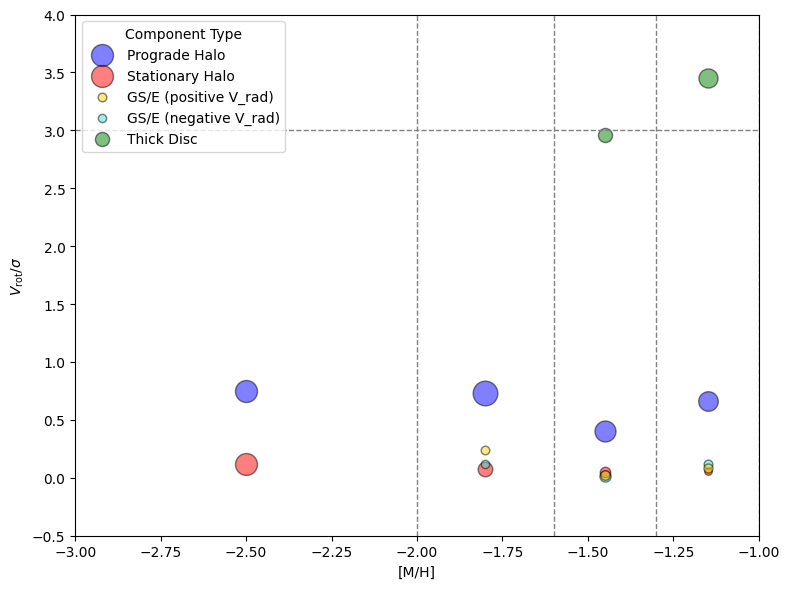

In [38]:
plt.figure(figsize=(8, 6))
plotted_labels = set()

for (min_mh, max_mh), bin_center, bin_label in zip(bins, bin_centers, bin_labels):
    fit_file = bin_files[bin_label]
    with open(fit_file, "rb") as f:
        gmm = pickle.load(f)

    n_components = gmm.K
    means = gmm.mean
    std_devs = np.sqrt(np.diagonal(gmm.covar, axis1=1, axis2=2))
    weights = gmm.amp

    print(f"{bin_label}: found {n_components} components")

    for i in range(n_components):
        Vrot = np.abs(means[i, 1])
        sigma_phi = std_devs[i, 1]
        V_over_sigma = Vrot / sigma_phi if sigma_phi > 0 else 0
        comp_fraction = weights[i]

        color = component_info.get((bin_label, i), 'gray')
        meaning_label = color_meaning.get(color, 'Other')

        show_label = meaning_label if meaning_label not in plotted_labels else None
        if show_label:
            plotted_labels.add(meaning_label)

        plt.scatter(bin_center, V_over_sigma,
                    s=500 * comp_fraction,
                    color=color,
                    edgecolor='black',
                    alpha=0.5,
                    label=show_label)

plt.axhline(3, color='gray', linestyle='--', linewidth=1)
for x in [-2, -1.6, -1.3, -1.0]:
    plt.axvline(x, color='gray', linestyle='--', linewidth=1)

plt.xlabel('[M/H]')
plt.ylabel(r'$V_{\mathrm{rot}} / \sigma$')
plt.xlim(-3, -1)
plt.ylim(-0.5, 4)

plt.legend(title='Component Type', loc='upper left')
plt.tight_layout()
plt.savefig('../figures/v_over_sigma_per_component.png', dpi=300)
plt.show()
